In [1]:
import random
import string
import numpy as np

import torch
import torch.nn.functional as F
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from dataclasses import dataclass, field

torch.set_printoptions(linewidth=120)
seed = 2**31 - 1

<hr>

# Multilayer Perceptron 
<hr>

In this notebook, we will develop a [multilayer perceptron](https://www.wikiwand.com/en/Multilayer_perceptron) (MLP) model to predict the next character in a sequence. Our approach is based on the paper ["A Neural Probabilistic Language Model" by Bengio et al. (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf),which presents a word-level language model. However, we will work with characters instead of words and follow a similar modeling approach. The goal is to train an MLP to learn the patterns and structure of a character sequence and use this knowledge to accurately predict the next character in the sequence.

```{figure} ./media/2_mlp_2022-10-26-19-49-45.png
:width: 400px
:name: MLP

Multilayer Perceptron with embeddings (Bengio et al. 2003)
```





## Setup

**Load the data**

In [2]:
# Load the data
with open('./data/names.txt', 'r') as f:
    names = f.read().splitlines()
print(f'Total # names: {len(names):.>25,}')
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [3]:
chars = '.' + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}

print('Encoder ch2ix:\n', ch2ix)
print('Decoder ix2ch:\n', ix2ch)
print('E.g. emma:', [ch2ix[c] for c in '.emma.'])

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]


**Dataset**

In [4]:
@dataclass
class Dataset:
    """
    Attributes:
    names: list of names.
    block_size: context length: how many characters do we take to predict the next one?
    """

    names: list[str]
    block_size: int = 3
    verbose: bool = False
    X: Tensor = field(init=False)
    Y: Tensor = field(init=False)

    def __post_init__(self) -> None:
        self._make_dataset()

    def _make_dataset(self) -> None:
        X, Y = [], []
        for w in self.names:
            if self.verbose:
                print(w)
            context = [0] * self.block_size
            for ch in w + '.':
                ix = ch2ix[ch]
                X.append(context)
                Y.append(ix)
                if self.verbose:
                    print(''.join(ix2ch[i] for i in context), '--->', ix2ch[ix])
                context = context[1:] + [ix]  # crop and append
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)

In [5]:
ds = Dataset(names[:1], block_size=3, verbose=True)
X, Y = ds.X, ds.Y


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


## Character embedding

To train the MLP to predict the next character in a sequence, we will represent each input character as a learnable m-dimensional vector. These vectors will be initialized randomly and will be adjusted during the training process. Characters that are similar to each other, such as vowels, will tend to be located closer to each other in this vector space.   

To embed our 27 characters into an m-dimensional space, we can create a 27xm lookup table (C) and randomly initialize it. To obtain the embedding vector for the i-th character, we can either encode the character as a one-hot vector and multiply it by C, or simply use the index to retrieve the i-th row of C. This will give us the m-dimensional vector that represents the i-th character, which can be used as input to the MLP model.

**one-hot vs index**

In [6]:
i = 5
C = torch.randn((27, 2))
# One-hot method
onehot = F.one_hot(torch.tensor(i), num_classes=27).float()
print(onehot @ C)
# Index method
print(C[i])

tensor([-2.1791, -1.0158])
tensor([-2.1791, -1.0158])


Using the index is much faster than using a one-hot vector.

In [7]:
%timeit onehot = F.one_hot(torch.tensor(i), num_classes=27).float()
%timeit index = C[i]

12.6 µs ± 275 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
930 ns ± 15.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


We can also index by a multi-dimentional tensor.

In [8]:
t = torch.tensor([[5, 5, 1], [2, 3, 4]])
print(t.shape)
print(C[t])
print(C[t].shape)

torch.Size([2, 3])
tensor([[[-2.1791, -1.0158],
         [-2.1791, -1.0158],
         [-0.5073, -1.2585]],

        [[-0.1092, -0.6073],
         [ 0.1240,  0.9430],
         [-1.2564,  1.0715]]])
torch.Size([2, 3, 2])


So to embed simultaniously all the integers of X, we simply do `C[X]`

In [9]:
print(X.shape)
print(C[X].shape)

torch.Size([5, 3])
torch.Size([5, 3, 2])


**Plot untrained embedding**

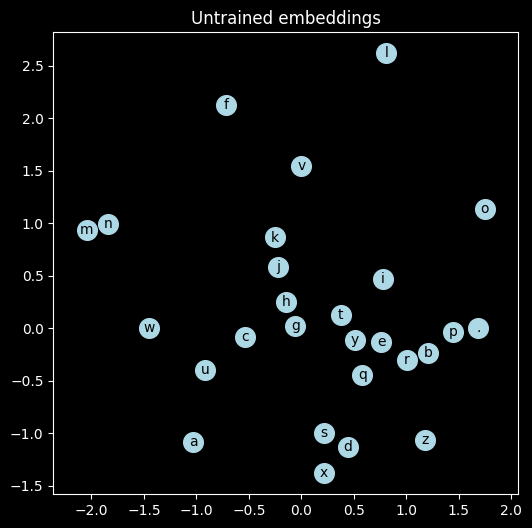

In [10]:
C = torch.randn((27, 2))
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0], C[:, 1], s=200, color='lightblue')
for i in range(27):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='black')
plt.axis('equal')
plt.title('Untrained embeddings')
plt.show()

## Building MLP step by step

We will build a MLP model has three components:
1. An **embedding matrix** `C` that maps each input character to an m-dimensional embedding vector
2. **A hidden layer** that applies the tanh non-linearity to the output of the concatenated embedding vectors
3. An **output layer** that produces logits from the output of the hidden layer and applies the softmax function to generate probabilities

The hidden layer has:
- Weights `W1` with shape (`block_size` * `emb_dim`, `hid_dim`)
- Bias b1 with shape (`hid_dim`)

The output layer has:
- Weights `W2` with shape (`hid_dim`, 27)
- Bias `b2` with shape (27)




**Hyperparameters**

In [11]:
block_size = X.shape[1]  # 3 (# input characters)
emb_dim = 2
hid_dim = 100

**Embedding**


In [12]:
C = torch.randn((27, emb_dim))  # (27, emb_dim)
emb = C[X]  # (bs, block_size, emb_dim)
print(emb.shape)
print(emb)

torch.Size([5, 3, 2])
tensor([[[-0.7129,  0.0984],
         [-0.7129,  0.0984],
         [-0.7129,  0.0984]],

        [[-0.7129,  0.0984],
         [-0.7129,  0.0984],
         [ 0.0692,  0.9171]],

        [[-0.7129,  0.0984],
         [ 0.0692,  0.9171],
         [ 0.9794, -1.0215]],

        [[ 0.0692,  0.9171],
         [ 0.9794, -1.0215],
         [ 0.9794, -1.0215]],

        [[ 0.9794, -1.0215],
         [ 0.9794, -1.0215],
         [ 1.0069,  0.5345]]])


To perform the matrix multiplication between the embedding tensor  (`bs`, `block_size`, `emb_dim`) and the weights `W1` (`block_size` * `emb_dim`, `hid_dim`) we must concatenate the blocks of the embedding tensor. This can be achieved using the [torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html) or with [torch.Tensor.view()](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html).

```{note}
`torch.Tensor.view()` is much more efficient, because unlike `torch.cat()`, no memory is being changed, created, copied or moved  by the view() operation. The storage is unchanged.
A good blogpost on how pytorch internaly works to stores tensors:[PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/).
```


In [13]:
%timeit emb.view(-1, block_size*emb_dim)
%timeit torch.cat(torch.unbind(emb, dim=1), dim=1)

1.44 µs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
6.65 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Concatenate embeddings with view

In [14]:
emb_concat = emb.view(-1, block_size * emb_dim)
print(emb_concat.shape)
print(emb_concat)

torch.Size([5, 6])
tensor([[-0.7129,  0.0984, -0.7129,  0.0984, -0.7129,  0.0984],
        [-0.7129,  0.0984, -0.7129,  0.0984,  0.0692,  0.9171],
        [-0.7129,  0.0984,  0.0692,  0.9171,  0.9794, -1.0215],
        [ 0.0692,  0.9171,  0.9794, -1.0215,  0.9794, -1.0215],
        [ 0.9794, -1.0215,  0.9794, -1.0215,  1.0069,  0.5345]])


**Hidden layer**

In [15]:
W1 = torch.randn(block_size * emb_dim, hid_dim)
b1 = torch.randn(hid_dim)

We can now calculate the hidden states h.

```{note}
The shape of `b1` is (hid_dim). We will add it to a tensor with shape (`block_size` * `emb_dim`, `hid_dim`). In order to do the addition `b1` will be broadcasted into a tensor of the same shape as `W1`. In other words, the bias will be added to all the rows of the tensor `emb` x` W1`.
```

In [16]:
h = emb_concat @ W1 + b1
print(h.shape)
print(h)

torch.Size([5, 100])
tensor([[ 2.9250e-01, -1.7270e-01, -4.4131e-02,  3.1039e+00, -1.8438e+00, -7.3514e-01, -1.5009e-01, -8.0428e-01,
          4.3553e-01,  2.0493e+00,  1.2477e+00, -2.3337e-01, -3.6995e+00,  1.9541e-01,  3.9950e-01, -6.5415e-01,
         -1.0628e+00, -1.1908e+00, -6.7111e-01, -2.2623e+00,  2.8200e+00, -8.0388e-01,  2.9225e-01,  9.5519e-01,
          2.4211e+00,  6.1082e-01,  2.2438e+00, -2.4678e+00, -3.2454e+00, -5.8777e-02, -1.0052e+00, -1.4054e+00,
          1.3817e+00,  1.0508e+00,  1.8156e+00,  8.8641e-01, -3.1273e+00,  4.1666e-01, -4.3277e-01,  1.4938e+00,
         -7.4963e-01, -5.1770e-02, -1.4402e+00,  9.0927e-01,  3.0679e-01,  3.4361e+00,  9.5012e-01,  8.5520e-01,
         -5.2127e-01,  1.1680e+00,  9.1671e-01,  5.0057e-01,  2.1331e+00, -2.9728e-01, -4.1146e+00,  1.7657e+00,
         -1.1038e+00,  1.4275e+00,  1.1980e+00,  1.7752e+00, -7.0758e-01,  6.2899e-01, -8.9479e-01, -3.9028e+00,
          2.8801e+00,  1.7202e+00,  1.4665e+00, -1.5325e+00, -1.5144e-01,  

Add tanh non-linear activation

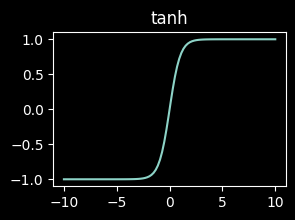

In [17]:
x = torch.linspace(-10, 10, 100)
y = torch.tanh(x)

plt.figure(figsize=(3, 2))
plt.plot(x, y)
plt.title('tanh')
plt.show()

In [18]:
h = torch.tanh(h)  # (bs, hid_dim)
print(h.shape)
print(h)

torch.Size([5, 100])
tensor([[ 2.8444e-01, -1.7100e-01, -4.4103e-02,  9.9598e-01, -9.5116e-01, -6.2620e-01, -1.4897e-01, -6.6642e-01,
          4.0993e-01,  9.6735e-01,  8.4764e-01, -2.2922e-01, -9.9878e-01,  1.9296e-01,  3.7952e-01, -5.7446e-01,
         -7.8674e-01, -8.3082e-01, -5.8571e-01, -9.7855e-01,  9.9292e-01, -6.6620e-01,  2.8421e-01,  7.4212e-01,
          9.8434e-01,  5.4470e-01,  9.7775e-01, -9.8573e-01, -9.9697e-01, -5.8709e-02, -7.6379e-01, -8.8651e-01,
          8.8134e-01,  7.8213e-01,  9.4840e-01,  7.0962e-01, -9.9616e-01,  3.9411e-01, -4.0763e-01,  9.0403e-01,
         -6.3493e-01, -5.1724e-02, -8.9373e-01,  7.2078e-01,  2.9752e-01,  9.9793e-01,  7.3984e-01,  6.9378e-01,
         -4.7868e-01,  8.2363e-01,  7.2434e-01,  4.6257e-01,  9.7232e-01, -2.8882e-01, -9.9947e-01,  9.4313e-01,
         -8.0185e-01,  8.9115e-01,  8.3305e-01,  9.4418e-01, -6.0916e-01,  5.5736e-01, -7.1375e-01, -9.9919e-01,
          9.9372e-01,  9.3789e-01,  8.9890e-01, -9.1084e-01, -1.5029e-01,  

**Output layer**

In [19]:
W2 = torch.randn(hid_dim, 27)
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2  # (bs, 27)
print(logits.shape)
print(logits)

torch.Size([5, 27])
tensor([[  3.5164,   7.9188, -14.8647,   0.8755,   1.6126,   7.5288,   2.6149,  16.4876,   2.9750,  -1.8132,  -1.3996,
          -4.4212, -11.2526,   3.1436, -15.8442,  -8.6950,   8.4528,  16.0921,   3.0693,   7.1922,   1.5154,   8.1665,
           2.7921,   3.4124,  10.3626,  -9.2752,  -1.7361],
        [ 12.9916,  10.1320, -10.9615,  -2.1059,   1.6970,   9.6038,  -0.3085,  18.8717,   2.9242,   5.9700,   1.9080,
           0.7925,  -0.4738,   6.4673,  -3.4823,  -4.2014,  10.1522,  14.5589,   1.6249,   5.8882,  -5.1297,   4.4828,
          -7.3323,   5.6532,  12.2617,  -6.5820,   2.5483],
        [ -6.0280,  -1.1630,  14.2044,  -1.3971,  -8.9427,  -0.7807,   5.4797, -12.5450,   5.1574,  -0.8181,  12.1904,
          -7.6255,  -4.9768,  -2.2345,  -2.6586,  -3.6031,  -5.8067,   7.4556,   2.7115,   3.8857,  10.9229,   6.9937,
          -9.3695,  -3.1185, -10.0213,  -7.4274,   2.3042],
        [ -5.7312, -14.1166,  19.7070,  -0.5077,  -4.8559,   6.1687, -11.1373,  -1.584

Transform logits into probabilities with softmax.

In [21]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)  # (bs, 27)
print(probs.shape)
print(probs)

torch.Size([5, 27])
tensor([[1.3876e-06, 1.1329e-04, 1.4436e-14, 9.8930e-08, 2.0676e-07, 7.6703e-05, 5.6332e-07, 5.9646e-01, 8.0750e-07,
         6.7244e-09, 1.0169e-08, 4.9546e-10, 5.3478e-13, 9.5581e-07, 5.4206e-15, 6.9014e-12, 1.9326e-04, 4.0164e-01,
         8.8735e-07, 5.4785e-05, 1.8761e-07, 1.4514e-04, 6.7254e-07, 1.2505e-06, 1.3047e-03, 3.8632e-12, 7.2630e-09],
        [2.7454e-03, 1.5728e-04, 1.0862e-13, 7.6177e-10, 3.4152e-08, 9.2749e-05, 4.5965e-09, 9.8235e-01, 1.1651e-07,
         2.4499e-06, 4.2173e-08, 1.3822e-08, 3.8963e-09, 4.0285e-06, 1.9235e-10, 9.3704e-11, 1.6049e-04, 1.3160e-02,
         3.1776e-08, 2.2575e-06, 3.7035e-11, 5.5369e-07, 4.0931e-12, 1.7847e-06, 1.3231e-03, 8.6669e-12, 8.0006e-08],
        [1.3926e-09, 1.8057e-07, 8.5231e-01, 1.4288e-07, 7.5501e-11, 2.6465e-07, 1.3853e-04, 2.0582e-12, 1.0036e-04,
         2.5493e-07, 1.1375e-01, 2.8186e-10, 3.9841e-09, 6.1845e-08, 4.0469e-08, 1.5737e-08, 1.7374e-09, 9.9920e-04,
         8.6960e-06, 2.8135e-05, 3.2023e-0

## Loss function

To calculate the loss of the model, we extract the predicted probability of the true label and compute the negative log-likelihood. The objective is to minimize this loss in order to improve the model's ability to predict the correct character in the sequence.    
Btw: Minimizing the negative log-likelihood is equivalent to maximizing the likelihood.  

**Negative log-likelihood loss (NLL)**

In [22]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(17.2929)

**Cross entropy loss**: The negative log-likelihood and cross entropy are two interpretations of the same formula.   

$\text{cross entropy}= H(p,q)= -\sum_x{p(x)log(q(x))}$   
with   
$x$: $\in$ classes   
$p(x)$: true probability distribution  
$q(x)$: predicted probability distribution

There are many good reasons to use `F.cross_entropy()` instead of manually calculating the loss. It's much more efficient and it's more numerically well behaved. The manual calculation uses `logits.exp()` and that can lead to overflow when an element of logits is very high. `F.cross_entropy()` avoids these kinds of problems.

In [23]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.2929)

## MLP model

In [24]:
class MLP:
    def __init__(self, block_size: int = 3, emb_dim: int = 2, hid_dim: int = 100, seed: int | None = None) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.block_size = block_size
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.C = torch.randn((27, emb_dim), generator=g)
        self.W1 = torch.randn((block_size * emb_dim, hid_dim), generator=g)
        self.b1 = torch.randn(hid_dim, generator=g)
        self.W2 = torch.randn((hid_dim, 27), generator=g)
        self.b2 = torch.randn(27, generator=g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
        self.n_parameters = sum(p.nelement() for p in self.parameters)

    def __call__(self, xs: Tensor) -> Tensor:
        """Does a forward pass and returns the logits"""
        emb = self.C[xs].view(-1, self.block_size * self.emb_dim)
        h = emb @ self.W1 + self.b1
        h = torch.tanh(h)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self) -> None:
        """Sets the gradients to None"""
        for p in self.parameters:
            p.grad = None

    def optimise_step(self, lr) -> None:
        """Updat the parameters"""
        for p in self.parameters:
            p.data += -lr * p.grad


### Training 1 batch

In [25]:
ds = Dataset(names, block_size=3)
X, Y = ds.X, ds.Y
Xsamp, Ysamp = X[:32], Y[:32]
model = MLP(block_size=3, hid_dim=100)
print(f'# parameters: {model.n_parameters}')


# parameters: 3481


In [26]:
emb_dim = 3
hid_dim = 100
model = MLP(block_size=3, emb_dim=emb_dim, hid_dim=hid_dim)
print(f'# parameters: {model.n_parameters}')

# parameters: 3808


In [27]:
losses = []
loss = 0
for _ in range(20000):
    logits = model(Xsamp)
    loss = F.cross_entropy(logits, Ysamp)
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(0.1)
print(f'{loss=}')


loss=tensor(0.2516, grad_fn=<NllLossBackward0>)


The low loss value of 0.2515 when training a single batch suggests that the model is overfitting, as it has a large number of parameters (3,481) relative to the small number of samples (32). This allows the model to memorize the true labels, rather than learning generalizable patterns.

It is also important to note that the loss will not be able to decrease to zero because there are multiple different y values for the same x values in the batch. For example, the 5 samples with all [0, 0, 0] x values have different y values. In this case, the minimum loss that can be achieved when the network has memorized all samples can be calculated as follows:

$H(p,q) = -\sum_x{p(x)log(q(x))}$   
where:   
$p(x)=1$ and $q(x)=1$ for all "unique" samples (not [0, 0, 0])   
$p(x)=1$ and $q(x)=1/5$ for the 5 "non-unique" samples ([0, 0, 0])   
therefore:   
$H(p,q) = -\frac{5\log(1/5)}{32}=0.2515$ 



### Training the full dataset

In [28]:
ds = Dataset(names, block_size=3)
X, Y = ds.X, ds.Y
model = MLP(block_size=3, emb_dim=2, hid_dim=100)
print(f'# parameters: {model.n_parameters}')

# parameters: 3481


In [29]:
losses = []
loss = 0

for _ in range(1000):
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(0.1)
print(f'{loss=}')


loss=tensor(2.5585, grad_fn=<NllLossBackward0>)


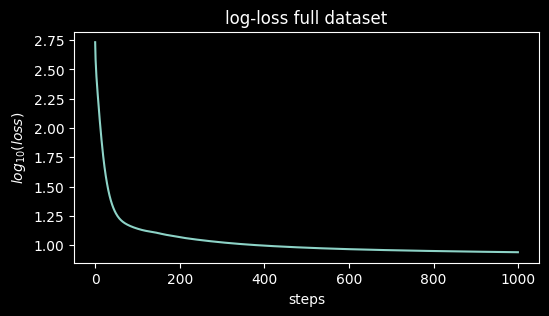

In [30]:
plt.figure(figsize=(6, 3))
plt.plot(np.log(losses))
plt.title('log-loss full dataset')
plt.xlabel('steps')
plt.ylabel(r'$log_{10}(loss)$')
plt.show()


Training for 1000 iterations on the full dataset is very slow. It takes more than 2 min to obtain a loss of 2.5610.

### Training with mini-batches

Instead of training on the full dataset, we can randomly select at each iteration a portion of the dataset, a mini-batch,  and do a forward and backward pass and update on each mini-batch. 

In [31]:
ds = Dataset(names, block_size=3)
X, Y = ds.X, ds.Y
model = MLP(block_size=3, hid_dim=100, seed=seed)
print(f'# parameters: {model.n_parameters}')


# parameters: 3481


In [32]:
def get_minibatch(X: Tensor, Y: Tensor, bs: int = 32, g: torch.Generator | None = None) -> tuple[Tensor, Tensor]:
    idx = torch.randint(0, X.shape[0], (bs,), generator=g)
    return X[idx], Y[idx]


bs = 320
n = 1000
losses = []
loss = 0
g = torch.Generator().manual_seed(seed)
for _ in range(n):
    Xb, Yb = get_minibatch(X, Y, bs, g)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(0.3)
print(f'Minibatch loss: {loss.item():.4f}')  # type: ignore


Minibatch loss: 2.4103


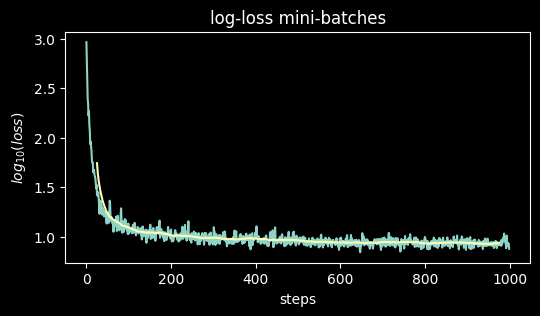

In [33]:
plt.figure(figsize=(6, 3))
plt.plot(range(len(losses)), np.log(losses))
ma = 50
losses_ma = np.convolve(losses, np.ones(ma) / ma, mode='valid')
plt.plot(range(ma // 2, len(losses_ma) + ma // 2), np.log(losses_ma))
plt.title('log-loss mini-batches')
plt.xlabel('steps')
plt.ylabel(r'$log_{10}(loss)$')
plt.show()


The use of minibatches in training can result in a decrease in the precision of the gradient calculation. While the gradient calculated from minibatches may not be as accurate as the gradient obtained from training on the entire dataset, it is still sufficient for practical use. It is generally more efficient to make progress with an approximate gradient by taking more steps, rather than obtaining an exact gradient but taking fewer steps. To accurately gauge the performance of the network, it is necessary to evaluate the loss on the entire dataset.

In [34]:
logits = model(X)
loss = F.cross_entropy(logits, Y)
print(f'{loss=}')


loss=tensor(2.5235, grad_fn=<NllLossBackward0>)


Training on mini-batches of size 320 is much faster than training on the full dataset. Training for 1000 iterations takes less than 1 sec and has a similar loss of 2.5756 compared to the loss of 2.5610 from training on the full dataset. 

## Train | valid | test split

If the number of parameters of a model is large enough then the model has enough capacity to memorize the training set. The loss will be very low, but if you sample from it then it will only produce samples it already saw in the trainingset. It won't produce new data.   
If you evaluate the loss on withheld names, i.e. samples that are not in the traininset, than that loss on those samples will be very high. The model is **overfitted**.  

The solution is to split the dataset into 3 sets: **training set, validation set and test set**. The training set (~80%) is for optimizing the parameters of the model. the validation set (~10%) is used to tune the hyperparameters of the model and the test set (~10%) is used to test the quality of the model at the very end. 

In [35]:
def train_valid_test_split(
    names: list, train_frac: float = 0.8, valid_frac: float = 0.1, seed: None | int = None
) -> tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]:
    """Function that split the dataset.
    It returns a tuple of (Xtrn, Ytrn, Xval, Yval, Xtst, Ytst)
    """
    if seed:
        random.seed(seed)
    words = names.copy()
    n = len(words)
    n1 = int(train_frac * n)
    n2 = n1 + int(valid_frac * n)
    random.shuffle(words)
    ds = Dataset(words[:n1])
    Xtrn, Ytrn = ds.X, ds.Y
    ds = Dataset(words[n1:n2])
    Xval, Yval = ds.X, ds.Y
    ds = Dataset(words[n2:])
    Xtst, Ytst = ds.X, ds.Y
    return Xtrn, Ytrn, Xval, Yval, Xtst, Ytst

In [36]:
ds = Dataset(names, block_size=3)
X, Y = ds.X, ds.Y
Xtrn, Ytrn, Xval, Yval, Xtst, Ytst = train_valid_test_split(names, seed=seed)


## Tuning hyperparameters

### Learning rate

One way to determin a reasonable learning rate is as follows: 
- Determine lower and upper bounds for the learning rate through trial and error. A learning rate that is too low may result in slow convergence, while a learning rate that is too high may result in unstable or oscillating loss.
- Train the network for one step using the lower bound learning rate. At each subsequent step, exponentially increase the learning rate up to the upper bound.
- Plot the learning rate (lr) against the loss. A reasonable learning rate is likely to be at the plateau of the plot.

**Upper and lower bound**

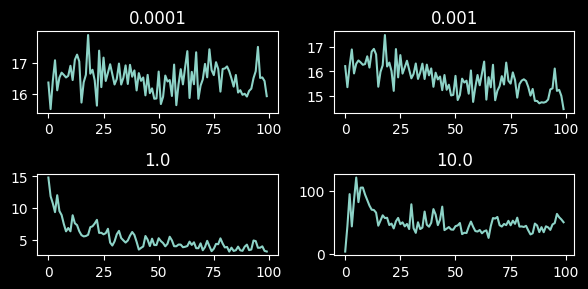

In [37]:
fix, axs = plt.subplots(2, 2, figsize=(6, 3))

bs = 320
n = 100
model = MLP(block_size=3, hid_dim=100)

for i, lr in enumerate([1e-4, 1e-3, 1e0, 1e1]):
    losses = []
    loss = 0
    g = torch.Generator().manual_seed(seed)
    for _ in range(n):
        Xb, Yb = get_minibatch(X, Y, bs, g)
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        losses.append(loss.item())
        model.zero_grad()
        loss.backward()
        model.optimise_step(lr)
    ax = axs.flatten()  # type: ignore
    ax[i].plot(losses)
    ax[i].set_title(lr)
plt.tight_layout()

**Traing with exponentially increasing lr**

In [38]:
lb, ub = 0.001, 1
n = 1000
bs = 32
lr_exp = torch.linspace(np.log10(lb), np.log10(ub), n)  # [-3 ... 0]
lrs = 10**lr_exp
g = torch.Generator().manual_seed(seed)
model = MLP(block_size=3, emb_dim=2, hid_dim=100, seed=seed)

losses = []
for i, lr in enumerate(lrs):
    Xb, Yb = get_minibatch(X, Y, bs, g)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(lr)


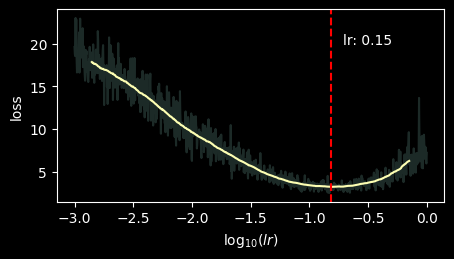

In [39]:
ma = 100
losses_ma = np.convolve(losses, np.ones(ma) / ma, mode='valid')

plt.figure(figsize=(5, 2.5))
plt.plot(lr_exp, losses, alpha=0.2)
plt.plot(lr_exp[ma // 2 - 1 : -ma // 2], losses_ma)
min_ix = np.argmin(losses_ma)
min_lr = lrs[min_ix + ma // 2].item()
plt.axvline(np.log10(min_lr), ls='--', c='r')
plt.text(np.log10(min_lr) + 0.1, 20, f'lr: {min_lr:.2}')

plt.ylabel('loss')
plt.xlabel(r'$\log_{10}(lr)$')
plt.show()

A reasonably good learning rate is somewhere between $10^{-1}$ and $10^{-0.5}$. 

**Weight decay**: We train our model with the decent learning rate till loss doesn't decrease anymore. Then we decay the learning rate with factor 10 and train a little longer.

In [40]:
def calc_loss(model: MLP, X, Y) -> float:
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss.item()


lr = 0.15
bs = 320
n = 500_000
decay_step = 495_000
batch_losses = []
train_losses = []
valid_losses = []
loss = 0

g = torch.Generator().manual_seed(seed)
model = MLP(block_size=3, emb_dim=2, hid_dim=100, seed=seed)

lrd = False
for i in range(n):
    # Lr decay
    if i > decay_step and not lrd:
        lr /= 10
        lrd = True
        print(f'Lr decay: {lr}')
    Xb, Yb = get_minibatch(X, Y, bs, g)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    batch_losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(lr)
    if i % 100 == 0:
        train_loss = calc_loss(model, Xtrn, Ytrn)
        train_losses.append(train_loss)
        valid_loss = calc_loss(model, Xval, Yval)
        valid_losses.append(valid_loss)
    if i % 1000 == 0:
        train_loss = calc_loss(model, Xtrn, Ytrn)
        valid_loss = calc_loss(model, Xval, Yval)
        print(f'Loss (train | valid) : {i:>7} | {train_loss:.4f} |  {valid_loss:.4f}')

print(f'Loss (total | test) : {calc_loss(model, X, Y):.4f} | {calc_loss(model, Xtst, Ytst):.4f}')

Loss (train | valid) :       0 | 16.3661 |  16.3210
Loss (train | valid) :    1000 | 2.5557 |  2.5623
Loss (train | valid) :    2000 | 2.4914 |  2.4944
Loss (train | valid) :    3000 | 2.4595 |  2.4617
Loss (train | valid) :    4000 | 2.4517 |  2.4549
Loss (train | valid) :    5000 | 2.4258 |  2.4264
Loss (train | valid) :    6000 | 2.4310 |  2.4323
Loss (train | valid) :    7000 | 2.4114 |  2.4124
Loss (train | valid) :    8000 | 2.4117 |  2.4152
Loss (train | valid) :    9000 | 2.4018 |  2.4057
Loss (train | valid) :   10000 | 2.3978 |  2.4002
Loss (train | valid) :   11000 | 2.3933 |  2.3987
Loss (train | valid) :   12000 | 2.3879 |  2.3888
Loss (train | valid) :   13000 | 2.3834 |  2.3859
Loss (train | valid) :   14000 | 2.3875 |  2.3913
Loss (train | valid) :   15000 | 2.3744 |  2.3775
Loss (train | valid) :   16000 | 2.3689 |  2.3739
Loss (train | valid) :   17000 | 2.3729 |  2.3774
Loss (train | valid) :   18000 | 2.3636 |  2.3654
Loss (train | valid) :   19000 | 2.3600 |  2.364

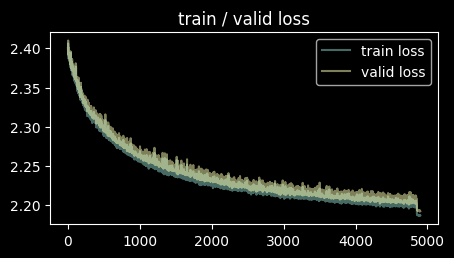

In [41]:
plt.figure(figsize=(5, 2.5))

plt.plot(train_losses[100:], alpha=0.5)
plt.plot(valid_losses[100:], alpha=0.5)
plt.legend(['train loss', 'valid loss'])
plt.title('train / valid loss')
plt.show()

We obtain a total loss of 2.17, which is a significant improvement from the loss of 2.45 of the bigram model!

### Hidden dim

During previous training, the training set loss was 2.1874 and the validation set loss was 2.1930. This suggests that overfitting is not occurring, and therefore it may be beneficial to increase the model size (i.e., number of parameters).

To identify the optimal hidden layer size, we will train the network using different configurations and monitor the total and validation loss. It is expected that the network will overfit with high values of hidden dimension.

In [42]:
lr = 0.15
bs = 320
n = 100_000
decay_step = 90_000

for i, hd in enumerate([50, 100, 200, 300, 400]):
    loss = 0
    g = torch.Generator().manual_seed(seed)
    model = MLP(block_size=3, emb_dim=2, hid_dim=hd, seed=seed)
    lrd = False
    for j in range(n):
        # Lr decay
        if j > decay_step and not lrd:
            lr /= 10
            lrd = True
        Xb, Yb = get_minibatch(X, Y, bs, g)
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        model.zero_grad()
        loss.backward()
        model.optimise_step(lr)
    print(f'hdim: {hd}, #paramters: {model.n_parameters}')
    print(f'Loss hdim={hd} (total | valid) : {calc_loss(model, X, Y):.4f} | {calc_loss(model, Xval, Yval):.4f}')

hdim: 50, #paramters: 1781
Loss hdim=50 (total | valid) : 2.2764 | 2.2813
hdim: 100, #paramters: 3481
Loss hdim=100 (total | valid) : 2.3847 | 2.3878
hdim: 200, #paramters: 6881
Loss hdim=200 (total | valid) : 2.6033 | 2.6118
hdim: 300, #paramters: 10281
Loss hdim=300 (total | valid) : 3.1716 | 3.1790
hdim: 400, #paramters: 13681
Loss hdim=400 (total | valid) : 13.6597 | 13.6473
hdim: 800, #paramters: 27281
Loss hdim=800 (total | valid) : 39.4532 | 39.5919


Increasing the width of the hidden layer results in worse validation loss and does not improve performance. This may suggest that the true bottleneck is not the hidden layer, but rather the size of the embeddings, or that the larger network requires more training steps to optimize its increased number of parameters.

### Embedding dim

In [43]:
lr = 0.15
bs = 320
n = 200_000
decay_step = 190_000

for i, ed in enumerate([2, 3, 4, 5]):
    loss = 0
    g = torch.Generator().manual_seed(seed)
    model = MLP(block_size=3, emb_dim=ed, hid_dim=100, seed=seed)
    lrd = False
    for j in range(n):
        # Lr decay
        if j > decay_step and not lrd:
            lr /= 10
            lrd = True
        Xb, Yb = get_minibatch(X, Y, bs, g)
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        model.zero_grad()
        loss.backward()
        model.optimise_step(lr)
    print(f'ed: {ed}, #paramters: {model.n_parameters}')
    print(f'Loss (total | valid) : {calc_loss(model, X, Y):.4f} | {calc_loss(model, Xval, Yval):.4f}')

ed: 2, #paramters: 3481
Loss (total | valid) : 2.2176 | 2.2249
ed: 3, #paramters: 3808
Loss (total | valid) : 2.3092 | 2.3099
ed: 4, #paramters: 4135
Loss (total | valid) : 2.4541 | 2.4564
ed: 5, #paramters: 4462
Loss (total | valid) : 3.3572 | 3.3692


## Visialize embeddings

In [44]:
emb_dim = 2
hid_dim = 50
n = 60000
bs = 25000
lr = 0.3

ds = Dataset(names, block_size=3)
X, Y = ds.X, ds.Y
g = torch.Generator().manual_seed(seed)
model = MLP(block_size=3, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
print(f'# parameters: {model.n_parameters}')
losses = []
loss = 0
Cs = []

for i in range(n):
    if i % 100 ==0:
        Cs.append(model.C.detach().clone().numpy())
    ixs = torch.randint(0, len(X), (bs,))
    Xb = X[ixs]
    Yb = Y[ixs]
    logits = model(Xb)
    loss = F.cross_entropy(logits, Y[ixs])
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(lr)
    if i % 1000 == 0:
        print(f'{i:>10} | {loss:.4f}')


# parameters: 1781
         0 | 11.7508
      1000 | 2.4502
      2000 | 2.4229
      3000 | 2.4022
      4000 | 2.3838
      5000 | 2.3740
      6000 | 2.3653
      7000 | 2.3560
      8000 | 2.3659
      9000 | 2.3516
     10000 | 2.3460
     11000 | 2.3334
     12000 | 2.3352
     13000 | 2.3294
     14000 | 2.3296
     15000 | 2.3258
     16000 | 2.3295
     17000 | 2.3153
     18000 | 2.3220
     19000 | 2.3158
     20000 | 2.3105
     21000 | 2.3101
     22000 | 2.3131
     23000 | 2.3080
     24000 | 2.3112
     25000 | 2.3015
     26000 | 2.3076
     27000 | 2.2866
     28000 | 2.3027
     29000 | 2.3081
     30000 | 2.2870
     31000 | 2.2971
     32000 | 2.2932
     33000 | 2.3012
     34000 | 2.2834
     35000 | 2.2952
     36000 | 2.2946
     37000 | 2.2808
     38000 | 2.2843
     39000 | 2.2731
     40000 | 2.2868
     41000 | 2.2803
     42000 | 2.2765
     43000 | 2.2833
     44000 | 2.2643
     45000 | 2.2739
     46000 | 2.2669
     47000 | 2.2761
     48000 | 2.2725


In [45]:
df = pd.DataFrame()
cols = [f'x{i}' for i in range(emb_dim)]
for i, emb in enumerate(Cs[:1000000]):
    emb = pd.DataFrame(emb, columns=cols)
    emb['ep'] = i
    emb['chr'] = list('.' + string.ascii_lowercase)
    emb.loc[emb['chr'].isin(list('aeiou')), 'col'] = 'r'
    emb.loc[~emb['chr'].isin(list('aeiou')), 'col'] = 'b'

    df = pd.concat([df, emb])
df = df.reset_index(drop=True)

In [46]:
fig = px.scatter(
    df,
    x='x0',
    y='x1',
    text='chr',
    color='col',
    animation_frame='ep',
    range_x=[df['x0'].min()-.2, df['x0'].max()+.2],
    range_y=[df['x1'].min()-.2, df['x1'].max()+.2],
)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 5  # type: ignore
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5  # type: ignore

fig.update_traces(marker={'size': 20, 'opacity': 0.35})
fig.update_layout(height=800, width=800)
fig

The visualization of the embeddings shows that the representations for vowels are grouped together, with the special character "." being distinct from the other characters.

## Sampling names

In [47]:
lr = 0.1
bs = 32
n = 200_000
decay_step = 100_000
loss = 0

g = torch.Generator().manual_seed(seed)
model = MLP(block_size=3, emb_dim=8, hid_dim=100, seed=seed)

lrd = False
for i in range(n):
    # Lr decay
    if i > decay_step and not lrd:
        lr /= 10
        lrd = True
    Xb, Yb = get_minibatch(X, Y, bs, g)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    batch_losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    model.optimise_step(lr)
    if i % 10000 == 0:
        train_loss = calc_loss(model, Xtrn, Ytrn)
        valid_loss = calc_loss(model, Xval, Yval)
        print(f'lr: {lr} | Loss (train | valid) : {i:>7} | {train_loss:.4f} |  {valid_loss:.4f}')

print(f'Loss (total | test) : {calc_loss(model, X, Y):.4f} | {calc_loss(model, Xtst, Ytst):.4f}')

lr: 0.1 | Loss (train | valid) :       0 | 16.4574 |  16.3855
lr: 0.1 | Loss (train | valid) :   10000 | 2.4252 |  2.4359
lr: 0.1 | Loss (train | valid) :   20000 | 2.3617 |  2.3645
lr: 0.1 | Loss (train | valid) :   30000 | 2.3248 |  2.3297
lr: 0.1 | Loss (train | valid) :   40000 | 2.3166 |  2.3252
lr: 0.1 | Loss (train | valid) :   50000 | 2.2781 |  2.2795
lr: 0.1 | Loss (train | valid) :   60000 | 2.2642 |  2.2660
lr: 0.1 | Loss (train | valid) :   70000 | 2.2945 |  2.2968
lr: 0.1 | Loss (train | valid) :   80000 | 2.2417 |  2.2405
lr: 0.1 | Loss (train | valid) :   90000 | 2.2510 |  2.2537
lr: 0.1 | Loss (train | valid) :  100000 | 2.2317 |  2.2333
lr: 0.01 | Loss (train | valid) :  110000 | 2.1682 |  2.1722
lr: 0.01 | Loss (train | valid) :  120000 | 2.1683 |  2.1723
lr: 0.01 | Loss (train | valid) :  130000 | 2.1659 |  2.1715
lr: 0.01 | Loss (train | valid) :  140000 | 2.1640 |  2.1689
lr: 0.01 | Loss (train | valid) :  150000 | 2.1648 |  2.1697
lr: 0.01 | Loss (train | valid) :

In [48]:
g = torch.Generator().manual_seed(seed)

for i in range(20):

    out = [] 
    context = [0] * block_size # '...'
    while True:
        logits = model(torch.tensor(context))  # predict log-counts
        p = torch.softmax(logits, 1) 
        ix = torch.multinomial(p, num_samples=1, replacement=False, generator=g).item()
        out.append(ix2ch[ix])  # type: ignore
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

dex.
marialynn.
roczitah.
mellistyna.
nolla.
kama.
da.
samiyah.
javer.
gotzi.
moriella.
ovie.
teda.
kaley.
maside.
enkaviyn.
rosba.
millie.
bron.
lasu.
